In [118]:
import numpy as np
import shutil
import os
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from PIL import ImageFile
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Train - val - test split

In [4]:
root_dir = '../data/data_151'
target_dir = '../data'

In [5]:
pokemon_list = ['Bulbasaur', 'Venusaur', 'Charmander', 'Charizard', 'Squirtle',
           'Blastoise', 'Pikachu', 'Eevee', 'Moltres', 'Zapdos', 
           'Articuno', 'Mewtwo', 'Lapras', 'Dragonite',
           'Alakazam', 'Gengar', 'Snorlax', 'Gyarados', 'Arcanine',
           'Jolteon', 'Vaporeon', 'Flareon', 'Scyther',
           'Pidgeot', 'Starmie', 'Magneton', 'Aerodactyl']

In [10]:
from collections import Counter

In [11]:
train_size = Counter()
val_size = Counter()
for pokemon in pokemon_list:
    files = os.listdir(f'{root_dir}/{pokemon}')
    random.seed(42)
    random.shuffle(files)
    
    train, validation = files[:-20], files[-20:]
    train_size.update({pokemon: len(train)})
    val_size.update({pokemon: len(validation)})
#     for folder, dataset in zip(['train', 'validation'],
#                                  [train, validation]):
#         for file in dataset:
#             if not os.path.exists(f'{target_dir}/{folder}/{pokemon}'):
#                 os.makedirs(f'{target_dir}/{folder}/{pokemon}')
#             shutil.copyfile(f'{root_dir}/{pokemon}/{file}',
#                             f'{target_dir}/{folder}/{pokemon}/{file}')

## Image Preprocessing

In [144]:
img_width, img_height = 128, 128
batch_size = 128

In [145]:
train_data_dir = f'{target_dir}/train'
validation_data_dir = f'{target_dir}/validation'
nb_train_samples = sum(train_size.values())
nb_validation_samples = sum(val_size.values())

In [146]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1. / 255,
#     shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img(f'{target_dir}/train/Pikachu/0-25.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                         save_to_dir=f'{target_dir}/prueba/', save_prefix='pikachu', 
                         save_format='png'):
    i += 1
    if i > 20:
        break

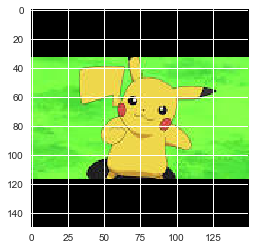

In [31]:
%matplotlib inline
from matplotlib.pyplot import imshow
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
sns.set()

def show_image(url):
    img = load_img(url)
    img.thumbnail((img_width, img_height), Image.ANTIALIAS, )
    new_img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    new_img.paste(img, ((img_width - img.size[0]) // 2, (img_height - img.size[1]) // 2))
    imshow(new_img)

#     x = img_to_array(new_img)
#     x = x.reshape((1,) + x.shape)
#     print(classes[np.argmax(model.predict(x))])
    
show_image(f'{target_dir}/train/Pikachu/0-25.png')
show_image(f'{target_dir}/train/Pikachu/pikachu-28.png')

In [147]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3775 images belonging to 27 classes.
Found 540 images belonging to 27 classes.


## Model

In [133]:
n_conv_layers = 4
n_kernels = [64] * n_conv_layers
model = Sequential()
model.add(BatchNormalization(input_shape=(img_width, img_height, 3)))

for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

In [134]:
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(pokemon_list)))
model.add(Activation('softmax'))

In [135]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [136]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 148, 148, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 72, 72, 64)        256       
__________

## MobileNet

In [42]:
from keras.applications import ResNet50
from keras.applications import MobileNet

In [75]:
model = MobileNet(input_shape=(img_width, img_height, 3), weights=None, classes=(len(pokemon_list)))

In [76]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 75, 75, 32)        0         
__________

## Execution

In [500]:
class LossHistory(Callback):    
    def __init__(self, logs={}):
        self.loss = []
        self.acc = []
        self.val_loss = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

In [ ]:
epochs = 10
batch_size = 128
history = LossHistory()
checkpointer = ModelCheckpoint(f'{target_dir}/models/CustomNet.h5', save_best_only=True)
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[history, checkpointer])

In [83]:
model.save(f'{target_dir}/models/CustomNet.h5')

In [84]:
model.save_weights(f'{target_dir}/models/CustomNet_weights.h5')

In [85]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

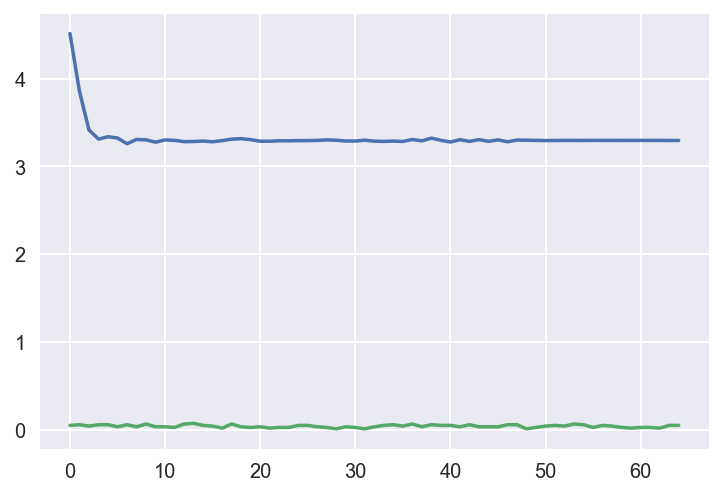

In [149]:
plt.plot(history.loss)
plt.plot(history.acc)

In [94]:
classes = {v: k for k, v in train_generator.class_indices.items()}
classes

{0: 'Aerodactyl',
 1: 'Alakazam',
 2: 'Arcanine',
 3: 'Articuno',
 4: 'Blastoise',
 5: 'Bulbasaur',
 6: 'Charizard',
 7: 'Charmander',
 8: 'Dragonite',
 9: 'Eevee',
 10: 'Flareon',
 11: 'Gengar',
 12: 'Gyarados',
 13: 'Jolteon',
 14: 'Lapras',
 15: 'Magneton',
 16: 'Mewtwo',
 17: 'Moltres',
 18: 'Pidgeot',
 19: 'Pikachu',
 20: 'Scyther',
 21: 'Snorlax',
 22: 'Squirtle',
 23: 'Starmie',
 24: 'Vaporeon',
 25: 'Venusaur',
 26: 'Zapdos'}

[[ 0.03730027  0.03754692  0.03689905  0.0371142   0.03681941  0.03718438
   0.03703959  0.0366781   0.03684741  0.03705745  0.03727493  0.03702953
   0.03746396  0.0371675   0.03669102  0.03688731  0.0367998   0.03677963
   0.03709458  0.03709059  0.0371174   0.03723644  0.03676238  0.03709849
   0.03690181  0.03722416  0.03689367]]
Alakazam


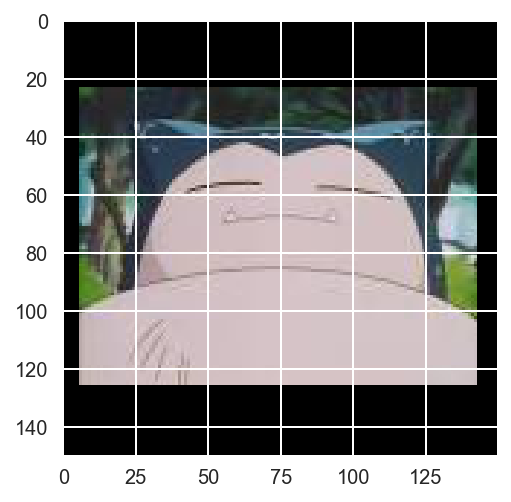

In [150]:
%matplotlib inline
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import pandas as pd

def predict_image(url):
    img = load_img(url)
    img.thumbnail((img_width, img_height), Image.ANTIALIAS)
    new_img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    new_img.paste(img, ((img_width - img.size[0]) // 2, (img_height - img.size[1]) // 2))
    imshow(new_img)

    x = img_to_array(new_img)
    x = x.reshape((1,) + x.shape)
    probs = pd.DataFrame()
    probs['Pokemon'] = [classes[idx] for idx in range(len(classes))]
    probs['Prob'] = model.predict(x)[0]    
#     probs = {classes[idx]: prob for idx,prob in enumerate(model.predict(x)[0])}
    print(model.predict(x))
    print(classes[np.argmax(model.predict(x))])
    return probs
    

probs = predict_image(f'{target_dir}/train/Snorlax/snorlax-25.png')

<Container object of 27 artists>

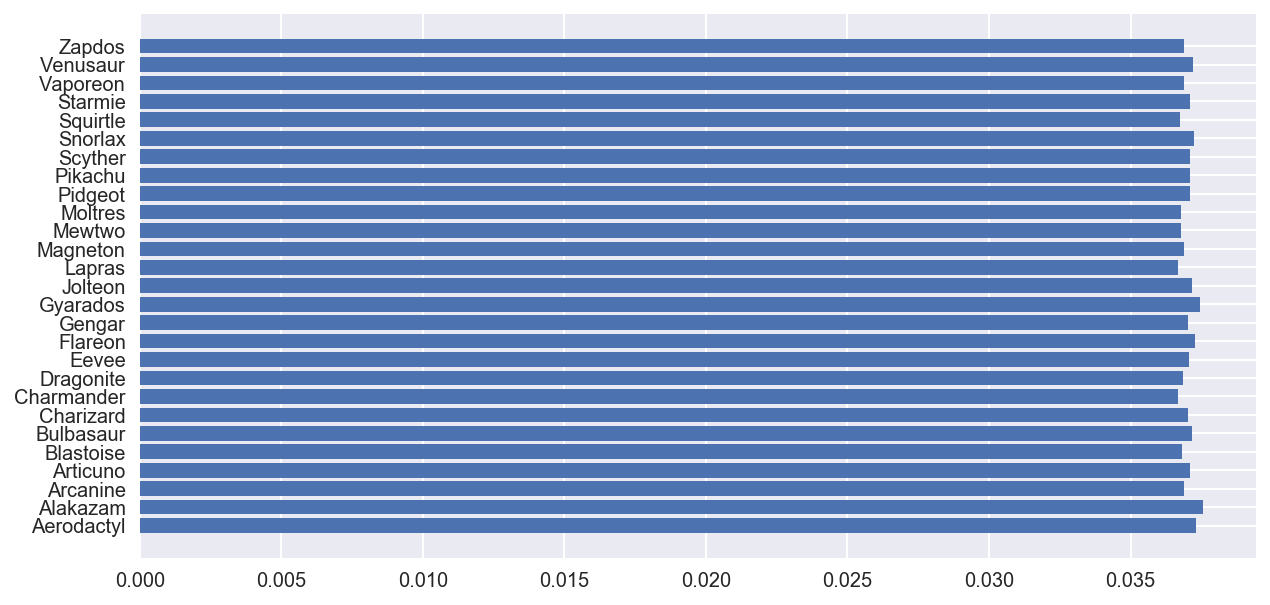

In [151]:
fig = plt.figure(figsize=(10,5))
plt.barh(probs['Pokemon'], probs['Prob'])

## Next Steps

- Transfer Learning
- Weight initialization
- More training less test data 100-20 OK
- Less classes? ~OK
- Check data augmentation OK

## Transfer Learning

Lapras/Lapras-42.png
(134, 76)


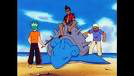

In [24]:
random_img = np.random.choice(train_generator.filenames)
random_img = random_img.replace('\\','/')
print(random_img)
print(Image.open(f'{target_dir}/train/{random_img}').size)
Image.open(f'{target_dir}/train/{random_img}')

In [25]:
widths = []
heights = []
for file in train_generator.filenames:
    file = file.replace('\\','/')
    im = Image.open(f'{target_dir}/train/{file}')
    widths += [im.size[0]]
    heights += [im.size[1]]

In [27]:
imstats = pd.DataFrame()
imstats['width'] = widths
imstats['height'] = heights

In [28]:
imstats.describe()

,width,height
count,3775.000000,3775.000000
mean,117.302781,106.144371
std,93.688584,93.298613
min,32.000000,30.000000
25%,84.000000,80.000000
50%,111.000000,97.000000
75%,143.000000,120.000000
max,1280.000000,1280.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000230EE6A9710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000230EE97E588>]], dtype=object)

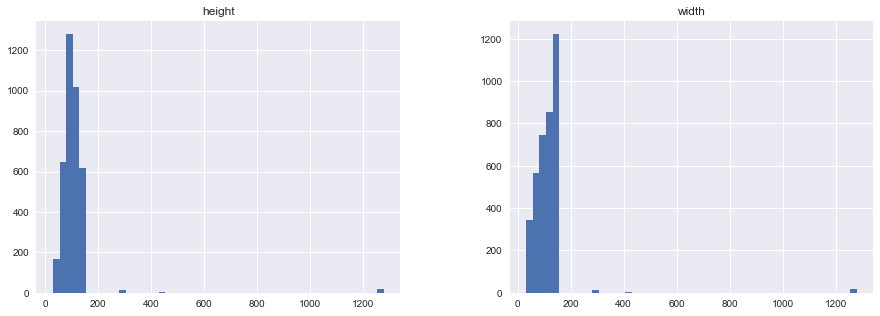

In [34]:
imstats.hist(bins=50, figsize=(15, 5))

## Image Preprocessing

In [83]:
img_width, img_height = 128, 128
batch_size = 128

In [84]:
train_data_dir = f'{target_dir}/train'
validation_data_dir = f'{target_dir}/validation'
nb_train_samples = sum(train_size.values())
nb_validation_samples = sum(val_size.values())

In [85]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [86]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img(f'{target_dir}/train/Pikachu/0-25.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                         save_to_dir=f'{target_dir}/prueba/', save_prefix='pikachu', 
                         save_format='png'):
    i += 1
    if i > 20:
        break

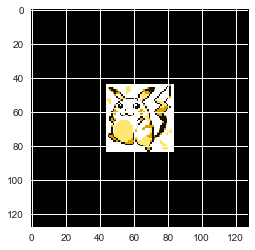

In [87]:
%matplotlib inline
from matplotlib.pyplot import imshow
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
sns.set()

def show_image(url):
    img = load_img(url)
    img.thumbnail((img_width, img_height), Image.ANTIALIAS, )
    new_img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    new_img.paste(img, ((img_width - img.size[0]) // 2, (img_height - img.size[1]) // 2))
    imshow(new_img)

#     x = img_to_array(new_img)
#     x = x.reshape((1,) + x.shape)
#     print(classes[np.argmax(model.predict(x))])
    
show_image(f'{target_dir}/train/Pikachu/0-25.png')
# show_image(f'{target_dir}/train/Pikachu/pikachu-28.png')

In [88]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3775 images belonging to 27 classes.
Found 540 images belonging to 27 classes.


In [89]:
train_datagen = ImageDataGenerator(preprocessing_function=None)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, shuffle=False,
    target_size=(img_width, img_height), 
    batch_size=batch_size)

Found 3775 images belonging to 27 classes.


## Load pretrained model

In [90]:
model = MobileNet(input_shape=(img_width, img_height, 3), include_top=False)
model.summary()

17227776/17225924 [==============================] - 12s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_

In [91]:
model.input, model.output

(<tf.Tensor 'input_3:0' shape=(?, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'conv_pw_13_relu/clip_by_value:0' shape=(?, 4, 4, 1024) dtype=float32>)

In [92]:
n_batch = train_generator.samples // batch_size
n_batch

29

In [93]:
train_generator.reset()

In [94]:
batch_x, batch_y = train_generator.next()
batch_x.shape, batch_y.shape

((128, 128, 128, 3), (128, 27))

In [95]:
from time import time
t0 = time()
output = model.predict_on_batch(batch_x)
elapsed = time() - t0
output.shape, elapsed

((128, 4, 4, 1024), 9.491491794586182)

## Generate predictions from MobileNet

In [96]:
train_generator.reset()
outputs_x = []
outputs_y = []

for i in range(n_batch):
    print('%d/%d...' % (i+1, n_batch), end='\r')
    batch_x, batch_y = train_generator.next()
    pred_batch = model.predict_on_batch(batch_x)
    outputs_x.append(pred_batch)
    outputs_y.append(batch_y)

C:\Users\RobertAlonso\Anaconda3\envs\kaggle\lib\site-packages\PIL\Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [98]:
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

((3712, 4, 4, 1024), (3712, 27))

In [99]:
np.savez_compressed('mobilenet-outputs', x=outputs_x, y=outputs_y)

In [60]:
outputs_x = np.load('mobilenet-outputs.npz')['x']
outputs_y = np.load('mobilenet-outputs.npz')['y']

## Top Layers

In [113]:
pokemon_model = Sequential()
pokemon_model.add(Flatten(input_shape=outputs_x.shape[1:]))
pokemon_model.add(Dense(500, activation='relu'))
pokemon_model.add(Dropout(0.5))
pokemon_model.add(Dense(len(pokemon_list)))

In [114]:
pokemon_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(0.001),
                     metrics=['accuracy'])
pokemon_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               8192500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 27)                13527     
Total params: 8,206,027
Trainable params: 8,206,027
Non-trainable params: 0
_________________________________________________________________


In [115]:
epochs = 50
batch_size = 128
history = LossHistory()
checkpointer = ModelCheckpoint(f'{target_dir}/models/CustomNet.h5', save_best_only=True)
log = pokemon_model.fit(outputs_x, outputs_y,
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[history])

Epoch 1/50
3712/3712 [==============================] - 9s 2ms/step - loss: 8.3232 - acc: 0.0412
Epoch 2/50
3712/3712 [==============================] - 8s 2ms/step - loss: 8.2983 - acc: 0.0439
Epoch 3/50
3712/3712 [==============================] - 8s 2ms/step - loss: 8.4088 - acc: 0.0461
Epoch 4/50
3712/3712 [==============================] - 9s 2ms/step - loss: 8.1123 - acc: 0.0374
Epoch 5/50
3712/3712 [==============================] - 8s 2ms/step - loss: 8.6136 - acc: 0.0409
Epoch 6/50
3712/3712 [==============================] - 8s 2ms/step - loss: 8.2235 - acc: 0.0471
Epoch 7/50
3712/3712 [==============================] - 9s 2ms/step - loss: 8.5296 - acc: 0.0369
Epoch 8/50
3712/3712 [==============================] - 10s 3ms/step - loss: 8.1510 - acc: 0.0393
Epoch 9/50
3712/3712 [==============================] - 9s 2ms/step - loss: 8.4297 - acc: 0.0480
Epoch 10/50
3712/3712 [==============================] - 9s 2ms/step - loss: 8.2746 - acc: 0.0439
Epoch 11/50
3712/3712 [=====

# Checkpoint

## MobileNet from scratch with ImageNet initialization

In [626]:
base_model = MobileNet(input_shape=(img_width, img_height, 3), include_top=False)

In [627]:
for i in range(22):
    base_model.layers[i].trainable = False
#     print(base_model.layers[i])

In [640]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 27)                13851     
Total params: 3,767,515
Trainable params: 3,714,971
Non-trainable params: 52,544
_________________________________________________________________


In [641]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.01),
              metrics=['accuracy'])

In [642]:
train_generator.reset()
validation_generator.reset()

In [ ]:
epochs = 10
batch_size = 128
history = LossHistory()
checkpointer = ModelCheckpoint(f'{target_dir}/models/CustomNet_fast.h5', save_best_only=True)
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[history, checkpointer])

Epoch 1/10


C:\Users\RobertAlonso\Anaconda3\envs\kaggle\lib\site-packages\PIL\Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


29/29 [==============================] - 676s 23s/step - loss: 4.7154 - acc: 0.0399 - val_loss: 15.5200 - val_acc: 0.0371
Epoch 2/10
10/29 [=========>....................] - ETA: 6:08 - loss: 3.6278 - acc: 0.0430

In [504]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [505]:
loss = pd.DataFrame()
val_loss = pd.DataFrame()
loss['loss'] = history.loss
loss['acc'] = history.acc
val_loss['loss'] = history.val_loss
val_loss['acc'] = history.val_acc
loss.to_csv(f'{target_dir}/train_loss_0.0001.csv', index=False)
val_loss.to_csv(f'{target_dir}/val_loss_0.0001.csv', index=False)

In [507]:
loss_001 = pd.read_csv(f'{target_dir}/train_loss_0.001.csv')
val_loss_001 = pd.read_csv(f'{target_dir}/val_loss_0.001.csv')

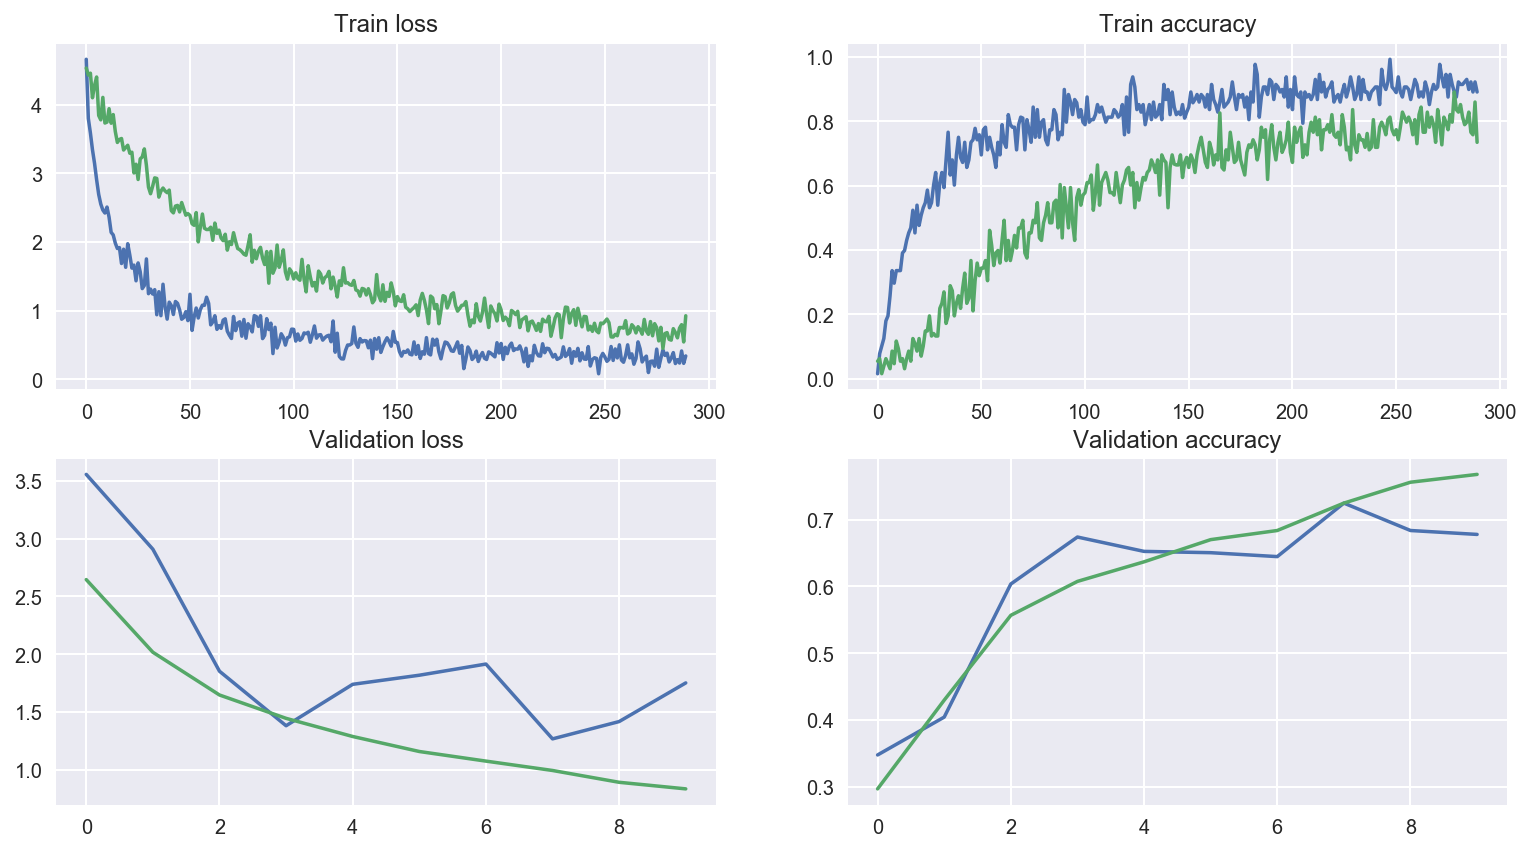

In [516]:
f, axarr = plt.subplots(2, 2, figsize=(13,7))
axarr[0, 0].set_title('Train loss')
axarr[0,0].plot(loss_001.loss)
axarr[0,0].plot(history.loss)
axarr[0,1].set_title('Train accuracy')
axarr[0,1].plot(loss_001.acc)
axarr[0,1].plot(history.acc)
axarr[1,0].set_title('Validation loss')
axarr[1,0].plot(val_loss_001.loss)
axarr[1,0].plot(history.val_loss)
axarr[1,1].set_title('Validation accuracy')
axarr[1,1].plot(val_loss_001.acc)
axarr[1,1].plot(history.val_acc)

In [527]:
classes = {v: k for k, v in train_generator.class_indices.items()}

In [571]:
%matplotlib inline
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import pandas as pd

def predict_image(url, model):
    img = load_img(url)
    img.thumbnail((img_width, img_height), Image.ANTIALIAS)
    new_img = Image.new('RGB', (img_width, img_height), (0, 0, 0))
    new_img.paste(img, ((img_width - img.size[0]) // 2, (img_height - img.size[1]) // 2))
    imshow(new_img)

    x = img_to_array(new_img)
    x = x.reshape((1,) + x.shape)
    x /= 255
    
    probs = pd.DataFrame()
    probs['Pokemon'] = [classes[idx] for idx in range(len(classes))]
    probs['Prob'] = model.predict(x)[0]    
#     probs = {classes[idx]: prob for idx,prob in enumerate(model.predict(x)[0])}
#     print(model.predict(x))
    print(classes[np.argmax(model.predict(x))])
    return probs

In [572]:
from keras.models import load_model
# model.save_weights(f'{target_dir}/models/CustomNet_weights.h5')

In [605]:
import keras
from keras.utils.generic_utils import CustomObjectScope

with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    model2 = load_model(f'{target_dir}/CustomNet_slow_10e-76v-80t.h5')

Articuno


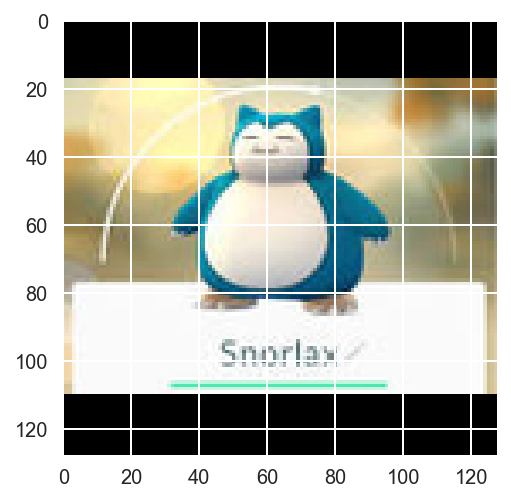

In [638]:
file_path = np.random.choice(validation_generator.filenames).replace('\\', '/')
file_path = f'{target_dir}/validation/' + file_path
probs = predict_image(file_path, model)

<Container object of 27 artists>

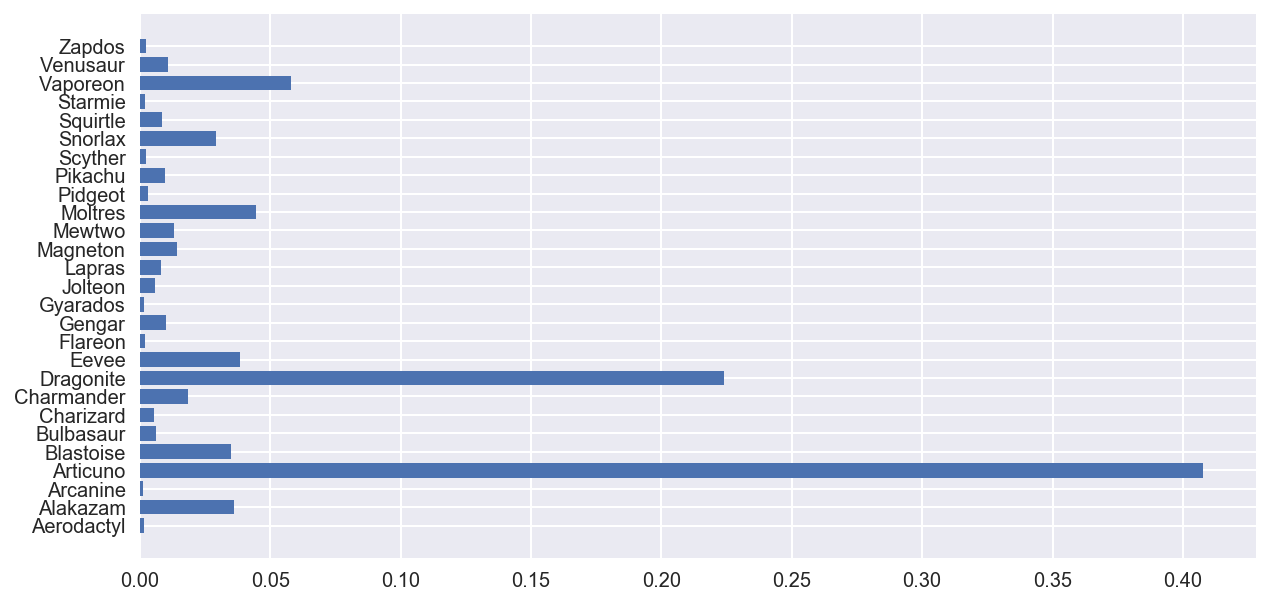

In [639]:
fig = plt.figure(figsize=(10,5))
plt.barh(probs['Pokemon'], probs['Prob'])